In [17]:
import os
import numpy as np
import time
import cv2
import shutil
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

from IPython import display
from PIL import Image
from ultralytics import YOLO

In [4]:
model = YOLO('/Users/juhyeon/python-workspace/ROADs/best.pt')

In [14]:
label2id = {'etc': 0,
            'PE드럼 정상': 1,
            'PE드럼 파손': 2,
            'PE방호벽 정상': 3,
            'PE방호벽 파손': 4,
            'PE안내봉 정상': 5,
            'PE안내봉 파손': 6,
            '라바콘 정상': 7,
            '라바콘 파손': 8,
            '시선유도봉 정상': 9,
            '시선유도봉 파손': 10,
            '제설함 정상': 11,
            '제설함 파손': 12,
            'PE sign origin': 13,
            'PE sign broken': 14,
            'PE휀스 정상': 15,
            'PE휀스 파손': 16}

# 반대로도 매핑할 수 있도록 딕셔너리 뒤집기!
id2label = {v: k for k, v in label2id.items()}

# 1.  image 한장에 모델 적용해보기

### best.pt 모델이 bbox 검출하는 것 확인!


image 1/1 /Users/juhyeon/python-workspace/ROADs/test/frame_1.jpg: 1088x1920 4 PE입간판 파손s, 420.9ms
Speed: 21.9ms preprocess, 420.9ms inference, 1.5ms postprocess per image at shape (1, 3, 1088, 1920)


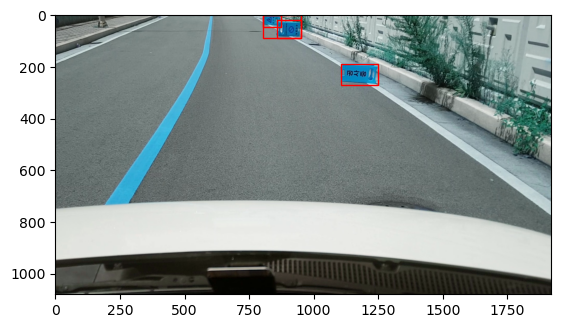

In [21]:
import matplotlib.patches as patches

# 예측 실행
results = model.predict(source='/Users/juhyeon/python-workspace/ROADs/test/frame_1.jpg')

# 예측 결과에서 이미지와 bounding box 정보를 가져옴
result = results[0]  # 첫 번째 결과를 선택
img = result.orig_img  # 원본 이미지를 가져옴
boxes = result.boxes.xyxy  # bounding box 정보를 가져옴

# 이미지 출력을 위한 figure와 axes를 생성
fig, ax = plt.subplots(1)
ax.imshow(img)

# 각 bounding box를 이미지에 그림
for box in boxes:
    rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()

In [32]:
results = model.predict(source='/Users/juhyeon/python-workspace/ROADs/test/frame_1.jpg')[0]
print(results)
print(results.boxes.data)

# draw results
for box in results.boxes.data:
    box = box.cpu()
    bbox = box[:4].numpy().astype(np.int32)
    conf, cls_id = box[4].item(), int(box[5].item())
    cls = id2label[cls_id]
    
    text = f"{cls} {round(conf, 2)}"
    img = cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (36, 255, 12), 3)
    cv2.putText(img, text, (bbox[0], bbox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 6)

ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'etc', 1: 'PE드럼 정상', 2: 'PE드럼 파손', 3: 'PE방호벽 정상', 4: 'PE방호벽 파손', 5: 'PE안내봉 정상', 6: 'PE안내봉 파손', 7: '라바콘 정상', 8: '라바콘 파손', 9: '시선유도봉 정상', 10: '시선유도봉 파손', 11: '제설함 정상', 12: '제설함 파손', 13: 'PE입간판 정상', 14: 'PE입간판 파손', 15: 'PE휀스 정상', 16: 'PE휀스 파손'}
obb: None
orig_img: array([[[ 79,  90,  87],
        [ 74,  85,  82],
        [ 73,  84,  81],
        ...,
        [170, 184, 182],
        [170, 184, 182],
        [170, 184, 182]],

       [[ 57,  68,  65],
        [ 52,  63,  60],
        [ 50,  61,  58],
        ...,
        [170, 184, 182],
        [170, 184, 182],
        [170, 184, 182]],

       [[ 48,  59,  56],
        [ 44,  55,  52],
        [ 42,  53,  50],
        ...,
        [170, 184, 182],
        [170, 184, 182],
        [170, 184, 182]],

       ...,

       [[ 49,  50,  46],
        [ 49,  50,  46],
        [ 48,  49,  45],
        .

In [33]:
# data: tensor([[xmin, ymin, xmax, ymax, confidence, class]])

for r in results:
    print(r.boxes.data.cpu().int())

tensor([[1106,  189, 1248,  269,    0,   14]], dtype=torch.int32)
tensor([[804,   0, 871,  43,   0,  14]], dtype=torch.int32)
tensor([[857,  19, 949,  87,   0,  14]], dtype=torch.int32)
tensor([[805,   0, 950,  87,   0,  14]], dtype=torch.int32)


# 2. frame을 순차적으로 가져와서 적용하기

In [15]:
image_folder_path = '/Users/juhyeon/python-workspace/ROADs/test'
test_paths = []

for filename in sorted(os.listdir(image_folder_path), key=lambda x: int(x.split("_")[1].split(".")[0])):
    if filename.endswith(".jpg") and filename.startswith("frame_"):
        file_path = os.path.join(image_folder_path, filename)
        test_paths.append(file_path)
        
test_paths

['/Users/juhyeon/python-workspace/ROADs/test/frame_1.jpg',
 '/Users/juhyeon/python-workspace/ROADs/test/frame_2.jpg',
 '/Users/juhyeon/python-workspace/ROADs/test/frame_3.jpg',
 '/Users/juhyeon/python-workspace/ROADs/test/frame_4.jpg',
 '/Users/juhyeon/python-workspace/ROADs/test/frame_5.jpg',
 '/Users/juhyeon/python-workspace/ROADs/test/frame_6.jpg',
 '/Users/juhyeon/python-workspace/ROADs/test/frame_7.jpg',
 '/Users/juhyeon/python-workspace/ROADs/test/frame_8.jpg',
 '/Users/juhyeon/python-workspace/ROADs/test/frame_9.jpg',
 '/Users/juhyeon/python-workspace/ROADs/test/frame_10.jpg',
 '/Users/juhyeon/python-workspace/ROADs/test/frame_11.jpg',
 '/Users/juhyeon/python-workspace/ROADs/test/frame_12.jpg',
 '/Users/juhyeon/python-workspace/ROADs/test/frame_13.jpg',
 '/Users/juhyeon/python-workspace/ROADs/test/frame_14.jpg',
 '/Users/juhyeon/python-workspace/ROADs/test/frame_15.jpg',
 '/Users/juhyeon/python-workspace/ROADs/test/frame_16.jpg',
 '/Users/juhyeon/python-workspace/ROADs/test/fram

In [18]:
image_folder_path = '/Users/juhyeon/python-workspace/ROADs/test'
output_folder_path = '/Users/juhyeon/python-workspace/ROADs/test_output_frames'

test_paths = []
for filename in sorted(os.listdir(image_folder_path), key=lambda x: int(x.split("_")[1].split(".")[0])):
    if filename.endswith(".jpg") and filename.startswith("frame_"):
        file_path = os.path.join(image_folder_path, filename)
        test_paths.append(file_path)

tracks = {}
IMGSZ = 640

#####   1. 이미지를 순차적으로 1~100 돌면서 검출 & 프레임당 가지고 있는 정보 가져오기(tracks에 저장됨)  #####
for i, image_path in enumerate(test_paths):
    print(image_path)
    
    frame = cv2.imread(image_path)
    results = model.track(frame, persist=True, imgsz=IMGSZ, verbose=False)
    
    # 트랙: {0: {'latest_bbox_info': {'bbox': tensor([550.9120, 516.0292, 591.8289, 719.9888]), 'cls_id': 0}}}
    print(f'트랙: {tracks}')
    
    # 딕셔너리: 각 객체는 track_id(box[4]), bbox(box[:4]), class_id(box[6])를 포함
    current_frame_track_info = {int(box[4].item()): {'bbox': box[:4], 
                                                     'cls_id': int(box[6].item())} for box in results[0].boxes.data}
    print(f'current_frame_track_info: {current_frame_track_info}')

    
#####   2. tracks{}에 저장된 각각의 track_id 별로 bbox 넓이 비교해서 제일 큰 것만 남도록 하는 과정   #####
    for track_id, track_info in current_frame_track_info.items():
        
        # 화면에 현재 프레임에서 검출된 객체 bbox 쳐서 그리기!
        bbox = track_info['bbox'].int().tolist()
        cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 3)
           
        if track_id in tracks:
            # 기존 정보가 없다면?
            if 'latest_bbox_info' not in tracks[track_id]:
                tracks[track_id]['latest_bbox_info'] = track_info
                tracks[track_id]['frame_i'] = i
                
            # 기존 정보가 있다면 비교!
            else:
                current_bbox_size = (track_info['bbox'][2] - track_info['bbox'][0]) * (track_info['bbox'][3] - track_info['bbox'][1])
                stored_bbox_size = (tracks[track_id]['latest_bbox_info']['bbox'][2] - tracks[track_id]['latest_bbox_info']['bbox'][0]) * \
                                   (tracks[track_id]['latest_bbox_info']['bbox'][3] - tracks[track_id]['latest_bbox_info']['bbox'][1])
                
                # 현재 bbox 넓이가 더 크면 원래 정보를 업데이트
                #  track_info : {'bbox': tensor([174.2584, 524.3750, 223.3572, 684.6147]), 'cls_id': 0}
                if current_bbox_size > stored_bbox_size:
                    tracks[track_id]['latest_bbox_info'] = track_info
                    tracks[track_id]['frame_i'] = i  # 가장 큰 bbox를 가진 프레임 정보 업데이트
        else:
            # 새로운 트랙 ID일 경우, 현재 프레임 정보 저장
            tracks[track_id] = {'latest_bbox_info': track_info, 'frame_i': i}
            
    cv2.imshow('Frame', frame)
    cv2.waitKey(1)  # 이미지를 1ms 동안 표시. 0을 입력하면 키 입력이 있을 때까지 이미지를 계속 표시

    
#####   3. 더 이상 다음 프레임에 해당 track_id가 검출되지 않는다면, tracks{}에 남아있는 bbox, fram_id 정보로 이미지 저장 #####

    # 이전 프레임에서 트래킹했던 track_ID 중에서 현재 프레임에서는 검출되지 않은 track_id를 찾아냄
    disappeared_track_ids = set(tracks.keys()) - set(current_frame_track_info.keys())
    
    # 더 이상 현재 프레임에서 검출되지 않는 track_id 에서 작업 수행
    for disappeared_track_id in disappeared_track_ids:
        try:
            latest_bbox_info = tracks[disappeared_track_id]['latest_bbox_info']
            output_path = os.path.join(output_folder_path, f'frame_{tracks[disappeared_track_id]["frame_i"]}_track_{disappeared_track_id}.jpg')
            
            # [xmin, ymin, xmax, ymax] 정수 coordinate
            bbox = latest_bbox_info['bbox'].int().tolist()
            
            cls_id = latest_bbox_info['cls_id']
            category_name = id2label[cls_id] if cls_id in id2label else f'Unknown_{cls_id}'
            
            # 가장 큰 bbox를 가진 프레임의 이미지를 다시 불러오기
            img_path = test_paths[tracks[disappeared_track_id]["frame_i"]]
            frame = cv2.imread(img_path)
            
            # (bbox[0], bbox[1]): 왼쪽 상단 좌표 (xmin, ymin)
            # (bbox[2], bbox[3]): 오른쪽 하단 좌표 (xmax, ymax)
            cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 3)
            
            # bbox 왼쪽 상단에서 10 픽셀 위에 이름쓰기
            cv2.putText(frame, category_name, (bbox[0], bbox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            
            cv2.imwrite(output_path, frame)
            print(f'Saved: {output_path} for Track ID: {disappeared_track_id}')

            # 해당 트랙을 더 이상 추적하지 않도록 목록에서 제거
            del tracks[disappeared_track_id]
            
        except Exception as e:
            print(f"Error occurred for Track ID {disappeared_track_id} on frame {i}: {e}")

# 프레임 보여주던 창 닫기!
cv2.destroyAllWindows()


#####    4.  프레임이 모두 재생되었는데, 마지막 프레임에 끝까지 검출되는 것이 있다면?   #####

# tracks{} 에서, 마지막까지 남은 track_id의 정보를 바탕으로 이미지 저장하고 끝냄
for track_id in tracks.keys():
    try:
        latest_bbox_info = tracks[track_id]['latest_bbox_info']
        output_path = os.path.join(output_folder_path, f'frame_{tracks[track_id]["frame_i"]}_track_{track_id}.jpg')
        
        bbox = latest_bbox_info['bbox'].int().tolist()
        
        cls_id = latest_bbox_info['cls_id']
        category_name = id2label[cls_id] if cls_id in id2label else f'Unknown_{cls_id}'
        
        img_path = test_paths[tracks[track_id]["frame_i"]]
        frame = cv2.imread(img_path)
        
        cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 3)
        
        cv2.putText(frame, category_name, (bbox[0], bbox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        cv2.imwrite(output_path, frame)
        print(f'Saved: {output_path} for Track ID: {track_id}')

    except Exception as e:
        print(f"Error occurred for Track ID {track_id} on the final frame : {e}")

/Users/juhyeon/python-workspace/ROADs/test/frame_1.jpg
트랙: {}
current_frame_track_info: {12: {'bbox': tensor([1105.1420,  172.6474, 1261.3624,  255.6970]), 'cls_id': 14}}
/Users/juhyeon/python-workspace/ROADs/test/frame_2.jpg
트랙: {12: {'latest_bbox_info': {'bbox': tensor([1105.1420,  172.6474, 1261.3624,  255.6970]), 'cls_id': 14}, 'frame_i': 0}}
current_frame_track_info: {12: {'bbox': tensor([1110.3779,  188.4172, 1256.6354,  268.7226]), 'cls_id': 14}}
/Users/juhyeon/python-workspace/ROADs/test/frame_3.jpg
트랙: {12: {'latest_bbox_info': {'bbox': tensor([1105.1420,  172.6474, 1261.3624,  255.6970]), 'cls_id': 14}, 'frame_i': 0}}
current_frame_track_info: {12: {'bbox': tensor([1113.8118,  198.3039, 1257.9342,  278.0218]), 'cls_id': 14}}
/Users/juhyeon/python-workspace/ROADs/test/frame_4.jpg
트랙: {12: {'latest_bbox_info': {'bbox': tensor([1105.1420,  172.6474, 1261.3624,  255.6970]), 'cls_id': 14}, 'frame_i': 0}}
current_frame_track_info: {12: {'bbox': tensor([1118.7888,  203.9635, 1265.05

In [ ]:
# /Users/juhyeon/python-workspace/ROADs/test/frame_1.jpg
# 트랙: {}
# current_frame_track_info: {1: {'bbox': tensor([1106.2971,  188.8095, 1250.1287,  265.7012]), 'cls_id': 14}}

# /Users/juhyeon/python-workspace/ROADs/test/frame_2.jpg
# 트랙: {1: {'latest_bbox_info': {'bbox': tensor([1106.2971,  188.8095, 1250.1287,  265.7012]), 'cls_id': 14}, 'frame_i': 0}}
# current_frame_track_info: {1: {'bbox': tensor([1109.8053,  191.2227, 1254.4624,  270.8381]), 'cls_id': 14}}

# /Users/juhyeon/python-workspace/ROADs/test/frame_3.jpg
# 트랙: {1: {'latest_bbox_info': {'bbox': tensor([1109.8053,  191.2227, 1254.4624,  270.8381]), 'cls_id': 14}, 'frame_i': 1}}
# current_frame_track_info: {1: {'bbox': tensor([1112.8164,  197.0379, 1258.6149,  277.7448]), 'cls_id': 14}}

# /Users/juhyeon/python-workspace/ROADs/test/frame_4.jpg
# 트랙: {1: {'latest_bbox_info': {'bbox': tensor([1112.8164,  197.0379, 1258.6149,  277.7448]), 'cls_id': 14}, 'frame_i': 2}}
# current_frame_track_info: {1: {'bbox': tensor([1117.7478,  201.5632, 1266.5599,  284.6284]), 'cls_id': 14}}

# /Users/juhyeon/python-workspace/ROADs/test/frame_5.jpg
# 트랙: {1: {'latest_bbox_info': {'bbox': tensor([1117.7478,  201.5632, 1266.5599,  284.6284]), 'cls_id': 14}, 'frame_i': 3}}
# current_frame_track_info: {1: {'bbox': tensor([1122.1049,  204.2974, 1275.1646,  288.0918]), 'cls_id': 14}}

# /Users/juhyeon/python-workspace/ROADs/test/frame_6.jpg
# 트랙: {1: {'latest_bbox_info': {'bbox': tensor([1122.1049,  204.2974, 1275.1646,  288.0918]), 'cls_id': 14}, 'frame_i': 4}}
# current_frame_track_info: {1: {'bbox': tensor([1125.9806,  207.2554, 1280.8333,  291.6559]), 'cls_id': 14}}

# 위 코드에 db, aws 로 넘어갈 데이터 넣어야함

In [1]:
!pip3 install psycopg2

In [2]:
!pip3 install geopy

# PostgreSQL DB

In [12]:
import psycopg2
from geopy.geocoders import Nominatim
from decimal import Decimal
from datetime import datetime


# 1. PostgreSQL 데이터베이스 연결
db_params = {'dbname': 'test',
             'user': 'postgres',
             'password': 'postgres',
             'host': 'localhost',
             'port': '5432'
            }

conn = psycopg2.connect(**db_params)
cursor = conn.cursor()


# 2. 현재 pc가 위치한 gps좌표 수집
response = requests.get('https://ipinfo.io')
data = response.json()

location = data.get('loc')
if location:
    lat, long = location.split(',')
else:
    print("위치 정보를 가져올 수 없습니다.")

    
# 3. 현재 날짜시간정보 수집
current_datetime = datetime.now()


# 4. 'gps_data' 테이블에 위에서 얻어낸 데이터들을 삽입
query = 'INSERT INTO gps_data (latitude, longitude, datetime) VALUES (%s, %s, %s)'
values = (latitude, longitude, current_datetime)


cursor.execute(query, values)
conn.commit()

cursor.close()
conn.close()

# aws S3

In [16]:
!pip3 install boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 6.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 6.9 MB/s eta 0:00:00
  Attempting uninstall: botocore
    Found existing installation: botocore 1.29.76
    Uninstalling botocore-1.29.76:
      Successfully uninstalled botocore-1.29.76
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.5.0 requires botocore<1.29.77,>=1.29.76, but you have botocore 1.34.23 which is incompatible.


In [29]:
s3 = s3_connection()

s3 bucket connected!


In [30]:
import os
import boto3

# AWS 계정 정보
aws_access_key_id = 
aws_secret_access_key = 
aws_region = 
bucket_name = 


# 업로드할 이미지 (/ROADs/test_img/ 하위에 캡쳐된 이미지가 저장되어 있음 )
local_image_directory = '/Users/juhyeon/python-workspace/ROADs/test_img/'
image_files = [f for f in os.listdir(local_image_directory) if f.endswith('.jpg')]


# AWS S3 클라이언트 생성
s3_client = boto3.client('s3', 
                         aws_access_key_id=aws_access_key_id,
                         aws_secret_access_key=aws_secret_access_key, 
                         region_name=aws_region)


# 각 이미지를 S3로 업로드 (파일이름은 똑같이 저장)
for image_file in image_files:
    local_image_path = os.path.join(local_image_directory, image_file)
    s3_object_key = f'finalprojectimage/{image_file}'

    # 이미지 업로드
    s3_client.upload_file(local_image_path, bucket_name, s3_object_key)

    print(f"Image uploaded to S3: {s3_object_key}")

Image uploaded to S3: finalprojectimage/test_img_1.jpg
Image uploaded to S3: finalprojectimage/test_img_2.jpg
Image uploaded to S3: finalprojectimage/test_img_3.jpg
